In [1]:
import numpy             as np
import gvar              as gv
import matplotlib.pyplot as plt
import pandas            as pd
import lsqfit
import itertools
from tqdm import tqdm

In [2]:
from b2heavy.FnalHISQMetadata import params as mData

In [3]:
from b2heavy.ThreePointFunctions.types3pts  import Ratio, RatioIO, ratio_prerequisites
from b2heavy.ThreePointFunctions.fitter3pts import RatioFitter, phys_energy_priors
from b2heavy.ThreePointFunctions.utils      import read_config_fit, dump_fit_object

In [4]:
DATA_DIR = '/Users/pietro/code/data_analysis/BtoD/Alex/'
DATA_2PT = '/Users/pietro/code/data_analysis/data/QCDNf2p1stag/B2heavy/report'

BINSIZE  = {
    'MediumCoarse':13,
    'Coarse-2':    16,
    'Coarse-1':    11,
    'Coarse-Phys': 19,
    'Fine-1':      16,
    'Fine-Phys':   16,
    'SuperFine':   22
}

JKFIT = True

In [15]:
ENSEMBLE_LIST = ['MediumCoarse','Coarse-2','Coarse-1','Coarse-Phys','Fine-1','Fine-Phys','SuperFine']
MOMLIST       = ['000','100','200','300','400']
RATIO_LIST    = ['XF','RPLUS','RMINUS','QPLUS']

In [71]:
Rs = []
for ens in ENSEMBLE_LIST:
    for mom in MOMLIST:
        aux = {'ensemble':ens, 'mom':mom}
        for rat in RATIO_LIST:
            if mom=='000' and rat!='RPLUS':
                continue
            elif mom!='000' and rat=='RPLUS':
                continue

            try:
                res = read_config_fit(
                    tag  = f'fit3pt_config_{ens}_{rat}_{mom}',
                    path = DATA_2PT,
                    jk   = JKFIT
                )
            except FileNotFoundError:
                continue

            try:
                r = gv.gvar(
                    res['ratio'][0].mean(),
                    res['ratio'][0].std() * np.sqrt(len(res['ratio'][0])-1)
                )
            except FileNotFoundError:
                r = None
            aux[rat] = r

            if 'xf' in rat:
                try:
                    aux['wrecoil'] = (1+r**2)/(1-r**2)
                except TypeError:
                    aux['wrecoil'] = None
        Rs.append(aux)

df = pd.DataFrame(Rs).set_index(['ensemble','mom'])
# df = pd.DataFrame(Rs).set_index(['ensemble'])
df

RPLUS           XF       RMINUS       QPLUS
ensemble     mom                                                  
MediumCoarse 000  1.0246(73)          NaN          NaN         NaN
             100         NaN  -0.0724(26)  -0.0772(50)  0.9657(48)
             200         NaN  -0.1421(37)  -0.1487(69)   0.885(10)
             300         NaN  -0.1991(50)  -0.1992(94)   0.766(18)
             400         NaN  -0.2341(90)   -0.223(11)   0.653(26)
Coarse-2     000  1.0177(65)          NaN          NaN         NaN
             100         NaN  -0.1218(55)  -0.1350(76)  0.9311(58)
             200         NaN  -0.2226(78)   -0.237(16)   0.753(15)
             300         NaN   -0.309(18)   -0.310(24)   0.535(44)
             400         NaN          NaN          NaN         NaN
Coarse-1     000  1.0091(67)          NaN          NaN         NaN
             100         NaN  -0.0913(44)  -0.1009(50)  0.9650(51)
             200         NaN  -0.1746(79)   -0.197(12)   0.851(13)
             300         NaN   -0.253(13)   -0.284(20)   0.725(21)
             400         NaN          NaN          NaN         NaN
Coarse-Phys  000  1.0098(47)          NaN          NaN         NaN
             100         NaN  -0.0668(29)  -0.0790(61)  0.9857(28)
             200         NaN  -0.1281(45)  -0.1456(64)  0.9355(47)
             300         NaN  -0.1878(84)   -0.217(10)  0.8558(87)
             400         NaN   -0.238(12)   -0.269(17)   0.753(13)
Fine-1       000  1.0380(60)          NaN          NaN         NaN
             100         NaN  -0.0751(14)  -0.0850(18)  0.9544(46)
             200         NaN  -0.1502(25)  -0.1680(30)  0.8615(86)
             300         NaN  -0.2216(52)  -0.2461(80)   0.731(13)
             400         NaN   -0.295(15)   -0.327(19)   0.611(20)
Fine-Phys    000  1.0234(40)          NaN          NaN         NaN
             100         NaN  -0.0596(11)  -0.0610(28)  0.9854(29)
             200         NaN  -0.1164(14)  -0.1232(38)  0.9316(53)
             300         NaN  -0.1687(21)  -0.1779(59)  0.8516(82)
             400         NaN  -0.2144(34)  -0.2229(86)   0.761(14)
SuperFine    000  1.0478(47)          NaN          NaN         NaN
             100         NaN  -0.0608(16)  -0.0642(15)  0.9874(34)
             200         NaN  -0.1235(47)  -0.1272(25)  0.9481(45)
             300         NaN  -0.1877(74)  -0.1846(48)  0.8663(78)
             400         NaN   -0.247(10)   -0.246(11)   0.736(23)

In [73]:
df.loc['Fine-1']

,RPLUS,XF,RMINUS,QPLUS
mom,,,,
000,1.0380(60),NaN,NaN,NaN
100,NaN,-0.0751(14),-0.0850(18),0.9544(46)
200,NaN,-0.1502(25),-0.1680(30),0.8615(86)
300,NaN,-0.2216(52),-0.2461(80),0.731(13)
400,NaN,-0.295(15),-0.327(19),0.611(20)


In [144]:
d = {}
for ens in ENSEMBLE_LIST:
    d[ens]= {}
    r = []
    for ratio in ['XF','RMINUS','QPLUS','RPLUS']:
        for mom in df.loc[ens].index:
            if df[ratio][ens,mom] is not np.NAN:
                res = read_config_fit(
                    tag  = f'fit3pt_config_{ens}_{ratio}_{mom}',
                    path = DATA_2PT,
                    jk   = JKFIT
                )
                r.append(res['ratio'][0])
        
    r = np.array(r)
    nmom = r.shape[0]
    if nmom>1:
        d[ens] = gv.gvar(
            r.mean(axis=1),
            np.cov(r)*(r.shape[1]-1)
        )
    else:
        d[ens] = gv.gvar(
            r.mean(),
            np.std(r) * np.sqrt(len(r[0])-1)
        )

In [157]:
x

array([-0.0724(27), -0.1421(37), -0.1991(50), -0.2341(90), -0.0772(50),
       -0.1487(69), -0.1992(94), -0.223(11), 0.9657(49), 0.885(10),
       0.766(18), 0.653(26), 1.0246(73)], dtype=object)

In [191]:
ff = {}
for ens in ENSEMBLE_LIST:
    ff[ens] = {}

    x = d[ens]

    rplus = x[-1]

    nmom = 3 if ens in ['Coarse-2','Coarse-1'] else 4

    xf, rminus, qplus = x[:-1].reshape(3,nmom)
    w = (1+xf**2)/(1-xf**2)

    hplus = np.sqrt(rplus) * qplus * (1. - rminus*xf)
    hminus = np.sqrt(rplus) * qplus * (1. - rminus*xf/xf**2)

    ff[ens]['w']  = w
    ff[ens]['h+'] = hplus
    ff[ens]['h-'] = hminus

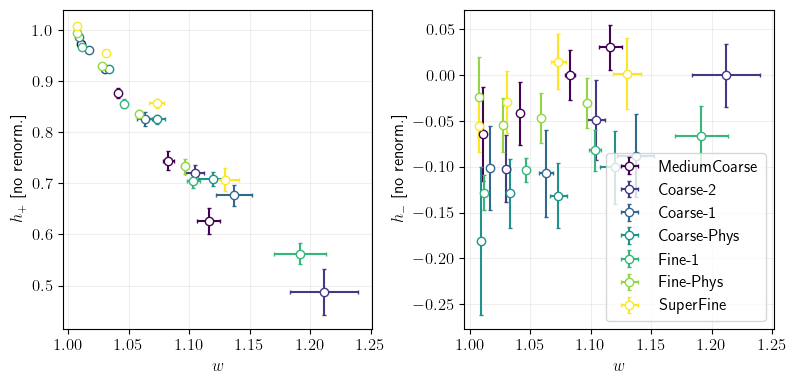

In [195]:
plt.rcParams['text.usetex'] = True
plt.rcParams['font.size'] = 12

f, ax = plt.subplots(1,2,figsize=(8,4),sharex=True)

color = plt.cm.viridis(np.linspace(0,1,len(ENSEMBLE_LIST)))

for i,ens in enumerate(ENSEMBLE_LIST):
    ax[0].errorbar(
        gv.mean(ff[ens]['w']),
        gv.mean(ff[ens]['h+']),
        xerr = gv.sdev(ff[ens]['w']),
        yerr = gv.sdev(ff[ens]['h+']),
        fmt     = 'o',
        ecolor  = color[i],
        mfc     = 'w', 
        color   = color[i], 
        capsize = 1.5,
        label   = ens
    )

    ax[1].errorbar(
        gv.mean(ff[ens]['w']),
        gv.mean(ff[ens]['h-']),
        xerr = gv.sdev(ff[ens]['w']),
        yerr = gv.sdev(ff[ens]['h-']),
        fmt     = 'o',
        ecolor  = color[i],
        mfc     = 'w', 
        color   = color[i], 
        capsize = 1.5,
        label   = ens
    )

ax[0].set_ylabel(r'$h_+$ [no renorm.]')
ax[0].set_xlabel(r'$w$')
ax[0].grid(alpha=0.2)

ax[1].legend()
ax[1].set_ylabel(r'$h_-$ [no renorm.]')
ax[1].set_xlabel(r'$w$')
ax[1].grid(alpha=0.2)

plt.tight_layout()